# 线性回归的从零开始实现

我们将从零开始实现整个方法，
包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [56]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集。
我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$$

In [57]:
# 生成数据集

def synthetic_data(w, b, num_examples):  
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))  # 生成特征X (1000,2) ,每一行是一个样本
    print(X.shape)  # 1000 * 2
    print(w)        # 1 * 2 
    # 具体计算过程见md
    y = torch.matmul(X, w) + b                      # 生成标签y (1000,1)，每一行是一个样本的标签
    print(y.shape)  # 1000 * 1 
    y += torch.normal(0, 0.01, y.shape)             # 加上噪声
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])  # 设定的真实权重
true_b = 4.2                      # 设定的真实偏差
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[:10],'\nlabel:', labels[:10])

torch.Size([1000, 2])
tensor([ 2.0000, -3.4000])
torch.Size([1000])
features: tensor([[-1.2222, -0.0426],
        [-0.9954, -0.3241],
        [ 0.3401,  0.2387],
        [ 0.3533,  0.3643],
        [-0.8090, -0.6839],
        [ 0.6557, -0.8893],
        [ 2.5462,  1.3106],
        [-1.0592,  0.3473],
        [ 0.3386, -0.7890],
        [-0.6126, -0.2199]]) 
label: tensor([[1.8925],
        [3.3263],
        [4.0710],
        [3.6670],
        [4.9161],
        [8.5410],
        [4.8143],
        [0.9094],
        [7.5535],
        [3.7180]])


`features`中的每一行都包含一个二维数据样本，
`labels`中的每一行都包含一维标签值（一个标量）

In [58]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-1.2222, -0.0426]) 
label: tensor([1.8925])


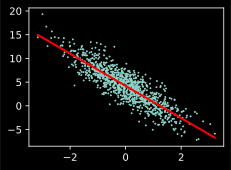

In [59]:
d2l.set_figsize()
# 生成散点图
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)
# 画出真实的线
d2l.plt.plot(features[:, 1].detach().numpy(), (true_w[1] * features[:, 1] + true_b).detach().numpy(), '-r', lw=2)

定义一个`data_iter`函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量

In [60]:
def data_iter(batch_size, features, labels):
    num_examples = len(features) # 样本的个数
    indices = list(range(num_examples))
    random.shuffle(indices) # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size): # 每次读取batch_size个样本
        # indices 是一个长度为num_examples的list，里面的每个元素是样本的索引
        # i是从0开始到num_examples，步长为batch_size
        # batch_indices是取出来的样本的索引
        # 最后一个batch可能不足一个batch_size
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)]) 
        # yield就是 return 返回一个值，并且记住这个返回的位置，下次迭代就从这个位置后开始。
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.0400, -0.4630],
        [-1.7072, -0.1584],
        [ 0.4834, -1.3873],
        [ 0.1005,  2.0488],
        [-0.6129, -0.8292],
        [-1.1747,  1.0224],
        [-1.1789, -0.7477],
        [-0.1638, -0.7121],
        [ 0.1795, -1.7259],
        [-0.5837,  0.1656]]) 
 tensor([[ 5.8682],
        [ 1.3304],
        [ 9.8795],
        [-2.5380],
        [ 5.8010],
        [-1.6271],
        [ 4.3610],
        [ 6.2901],
        [10.4356],
        [ 2.4631]])


在我们开始用小批量随机梯度下降优化我们的模型参数之前
我们需要先有一些参数

In [61]:
w = torch.normal(0, 0.01, size=(2,), requires_grad=True)
print(w)
b = torch.zeros(1, requires_grad=True)
print(b)

tensor([ 0.0072, -0.0121], requires_grad=True)
tensor([0.], requires_grad=True)


定义模型，将模型的输入和参数同模型的输出关联起来

In [62]:
def linreg(X, w, b):  
    """线性回归模型"""
    # X:(10,2) w:(2,) b:(1,) 
    # X的每一行是一个样本，w是每个特征的权重，b是偏差
    # Xw+b是一个列向量，每一行是一个样本的预测值
    return torch.matmul(X, w) + b


定义损失函数

In [63]:
def squared_loss(y_hat, y):  
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

定义优化算法

In [64]:
def sgd(params, lr, batch_size):  
    """小批量随机梯度下降"""
    with torch.no_grad():# 已经计算好梯度，不需要再计算梯度
        for param in params:
            param -= lr * param.grad / batch_size
            # 为什么要除以batch_size，因为求得的梯度是一个batch的梯度之和，所以要除以batch_size求平均
            param.grad.zero_()

训练过程

In [65]:
lr = 0.03
num_epochs = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.032204
epoch 2, loss 0.000118
epoch 3, loss 0.000050
epoch 4, loss 0.000050
epoch 5, loss 0.000050
epoch 6, loss 0.000050
epoch 7, loss 0.000050
epoch 8, loss 0.000050
epoch 9, loss 0.000050
epoch 10, loss 0.000050


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [66]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0004,  0.0006], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0006], grad_fn=<RsubBackward1>)
